In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional,Input, Layer
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [127]:
df = pd.read_csv('specific_region_data.csv', index_col='Date', parse_dates=True)

# Ensure the index is a DatetimeIndex with the correct format (if necessary)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df

,Latitude,Longitude,Soil_Moisture
Date,,,
2020-01-01,42.154439,-119.161597,0.234979
2020-01-02,42.154439,-119.161597,0.233168
2020-01-03,42.154439,-119.161597,0.233806
2020-01-04,42.154439,-119.161597,0.237789
2020-01-05,42.154439,-119.161597,0.238714
...,...,...,...
2024-09-27,42.154681,-119.161253,0.276903
2024-09-28,42.154681,-119.161253,0.276044
2024-09-29,42.154681,-119.161253,0.275907


In [4]:
df.describe()

,Latitude,Longitude,Soil_Moisture
count,1744.000000,1744.000000,1744.000000
mean,42.154477,-119.161543,0.230867
std,0.000088,0.000125,0.026869
min,42.154439,-119.161597,0.185266
25%,42.154439,-119.161597,0.211468
50%,42.154439,-119.161597,0.227382
75%,42.154439,-119.161597,0.243222
max,42.154681,-119.161253,0.331327


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1744 non-null   object 
 1   Latitude       1744 non-null   float64
 2   Longitude      1744 non-null   float64
 3   Soil_Moisture  1744 non-null   float64
dtypes: float64(3), object(1)
memory usage: 54.6+ KB


In [6]:
df.isnull().sum()

Date             0
Latitude         0
Longitude        0
Soil_Moisture    0
dtype: int64

In [128]:
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

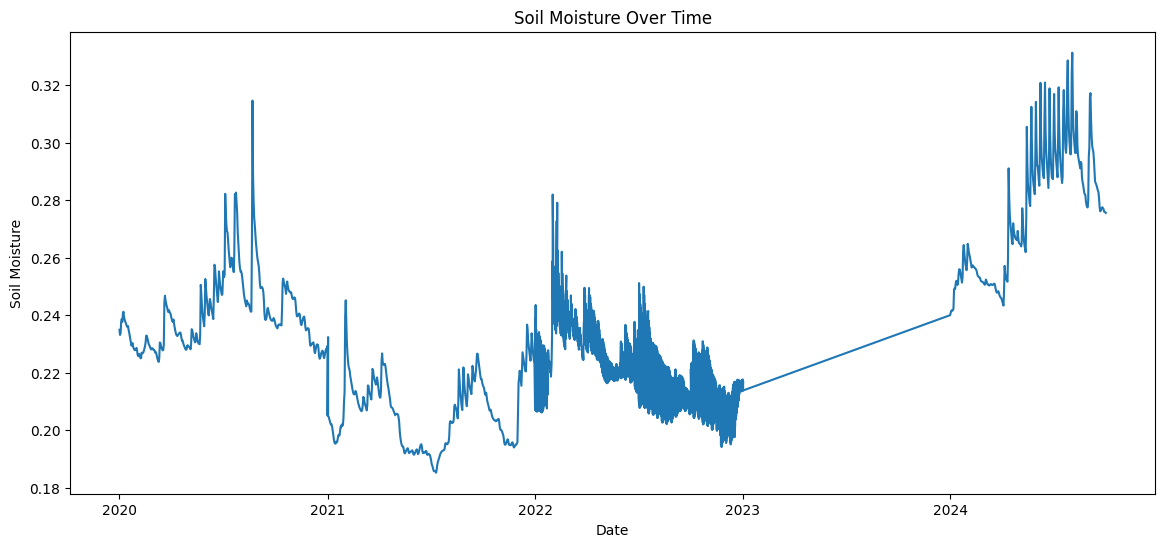

In [9]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Soil_Moisture'])
plt.title('Soil Moisture Over Time')
plt.xlabel('Date')
plt.ylabel('Soil Moisture')
plt.show()


In [130]:
features = ['Soil_Moisture', 'sin_day', 'cos_day', 'month']

# Normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

In [131]:
df_scaled

array([[3.40355752e-01, 5.08604320e-01, 9.99930644e-01, 0.00000000e+00],
       [3.27954505e-01, 5.17202627e-01, 9.99708725e-01, 0.00000000e+00],
       [3.32328657e-01, 5.25795845e-01, 9.99338934e-01, 0.00000000e+00],
       ...,
       [6.20568064e-01, 6.47323178e-05, 4.91933702e-01, 7.27272727e-01],
       [6.20310568e-01, 0.00000000e+00, 5.00534694e-01, 7.27272727e-01],
       [6.18645776e-01, 8.32267526e-05, 5.09135526e-01, 8.18181818e-01]])

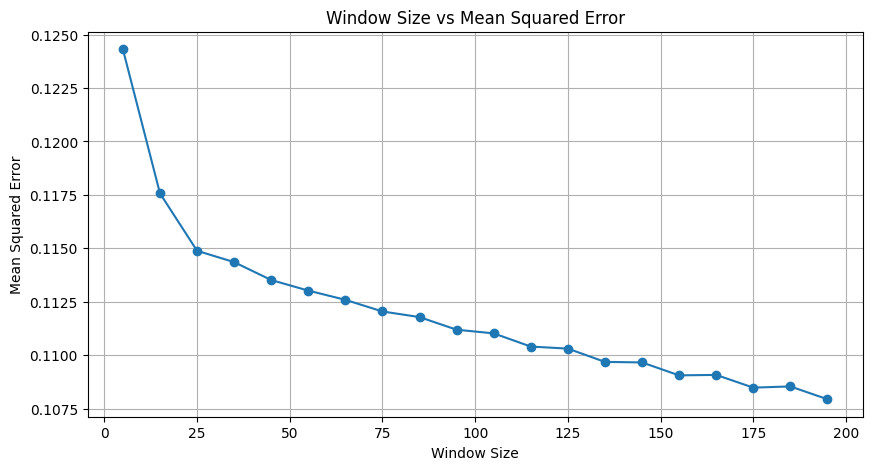

Best window size: 195


In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Assuming `df_scaled` is the array containing soil moisture values
time_series = df_scaled.flatten()  # Flatten the array to make it a 1D array if needed

# Function to apply a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Function to evaluate the window size using TimeSeriesSplit
def evaluate_window_size(time_series, window_size_range):
    tscv = TimeSeriesSplit(n_splits=5)  # Use 5 splits for cross-validation
    mean_errors = []

    for window_size in window_size_range:
        errors = []
        for train_index, test_index in tscv.split(time_series):
            train, test = time_series[train_index], time_series[test_index]

            # Skip if the window size is larger than the training set
            if len(train) < window_size:
                continue

            # Compute moving average on the train set
            smoothed_train = moving_average(train, window_size)

            # Adjust the length of train and test to make them consistent
            adjusted_train_len = len(smoothed_train)
            adjusted_test_len = min(len(test), adjusted_train_len)  # Make test length fit within smoothed_train length

            # Use the last predictions from smoothed_train for the test set
            predictions = smoothed_train[-adjusted_test_len:]

            # Slice test data to match the prediction length
            test_adjusted = test[:adjusted_test_len]

            # Calculate mean squared error only when lengths are the same
            error = mean_squared_error(test_adjusted, predictions)
            errors.append(error)

        # Calculate the mean error for each window size
        mean_errors.append(np.mean(errors))

    return mean_errors

# Define a range of window sizes to test
window_size_range = range(5, 200, 10)

# Calculate mean errors for each window size
mean_errors = evaluate_window_size(time_series, window_size_range)

# Plot the results to visualize the best window size
plt.figure(figsize=(10, 5))
plt.plot(window_size_range, mean_errors, marker='o')
plt.title("Window Size vs Mean Squared Error")
plt.xlabel("Window Size")
plt.ylabel("Mean Squared Error")
plt.grid()
plt.show()

# Find the best window size with the lowest mean squared error
best_window_size = window_size_range[np.argmin(mean_errors)]
print(f"Best window size: {best_window_size}")


First preprocessing

In [132]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # Target is soil moisture
    return np.array(X), np.array(y)


In [138]:
window_size = 195  # Time window to look back
X, y = create_sequences(df_scaled, window_size)

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], len(features)))

# Train-test split (95% train, 5% test)
split = int(0.95 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [140]:
# Assuming window_size and len(features) are predefined
model = Sequential()

# First Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(200, return_sequences=True, input_shape=(window_size, len(features)))))
model.add(Dropout(0.1))

# Second LSTM Layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.1))

# Third LSTM Layer
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.1))

# Dense Layers for Output
model.add(Dense(25))
model.add(Dense(1))

# Build the model explicitly
model.build(input_shape=(None, window_size, len(features)))

# Now you can call summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 195, 400)         328000    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 195, 400)          0         
                                                                 
 lstm_10 (LSTM)              (None, 195, 100)          200400    
                                                                 
 dropout_10 (Dropout)        (None, 195, 100)          0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                      

In [37]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
183/183 [==============================] - 15s 58ms/step - loss: 0.0543 - lr: 1.0000e-08
Epoch 2/100
183/183 [==============================] - 10s 56ms/step - loss: 0.0543 - lr: 1.1220e-08
Epoch 3/100
183/183 [==============================] - 10s 57ms/step - loss: 0.0540 - lr: 1.2589e-08
Epoch 4/100
183/183 [==============================] - 11s 59ms/step - loss: 0.0537 - lr: 1.4125e-08
Epoch 5/100
183/183 [==============================] - 11s 61ms/step - loss: 0.0539 - lr: 1.5849e-08
Epoch 6/100
183/183 [==============================] - 11s 59ms/step - loss: 0.0537 - lr: 1.7783e-08
Epoch 7/100
183/183 [==============================] - 10s 53ms/step - loss: 0.0536 - lr: 1.9953e-08
Epoch 8/100
183/183 [==============================] - 9s 49ms/step - loss: 0.0537 - lr: 2.2387e-08
Epoch 9/100
183/183 [==============================] - 9s 48ms/step - loss: 0.0533 - lr: 2.5119e-08
Epoch 10/100
183/183 [==============================] - 10s 53ms/step - loss: 0.0529 - lr: 2.

(1e-08, 0.001, 0.0, 100.0)

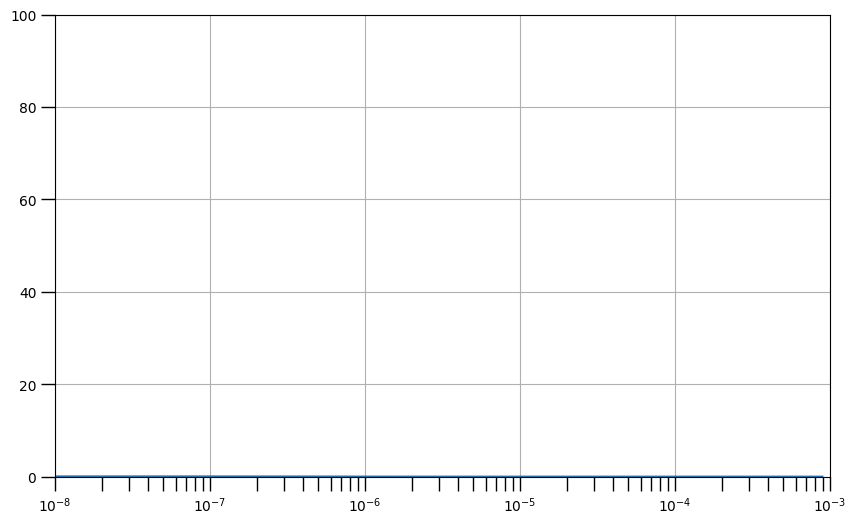

In [38]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [141]:
tf.keras.backend.clear_session()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# Early Stopping Callback
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train Model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
46/46 [==============================] - 9s 103ms/step - loss: 0.0205 - val_loss: 0.0186
Epoch 2/200
46/46 [==============================] - 3s 74ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 3/200
46/46 [==============================] - 3s 74ms/step - loss: 0.0039 - val_loss: 0.0058
Epoch 4/200
46/46 [==============================] - 4s 80ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 5/200
46/46 [==============================] - 4s 83ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 6/200
46/46 [==============================] - 4s 82ms/step - loss: 0.0031 - val_loss: 0.0060
Epoch 7/200
46/46 [==============================] - 4s 80ms/step - loss: 0.0032 - val_loss: 0.0053
Epoch 8/200
46/46 [==============================] - 4s 82ms/step - loss: 0.0029 - val_loss: 0.0052
Epoch 9/200
46/46 [==============================] - 4s 81ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 10/200
46/46 [==============================] - 4s 84ms/step - loss: 0.0028 - val_loss: 0.006

In [143]:
loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")


3/3 [==============================] - 0s 90ms/step - loss: 0.0054
Test Loss: 0.005358928348869085


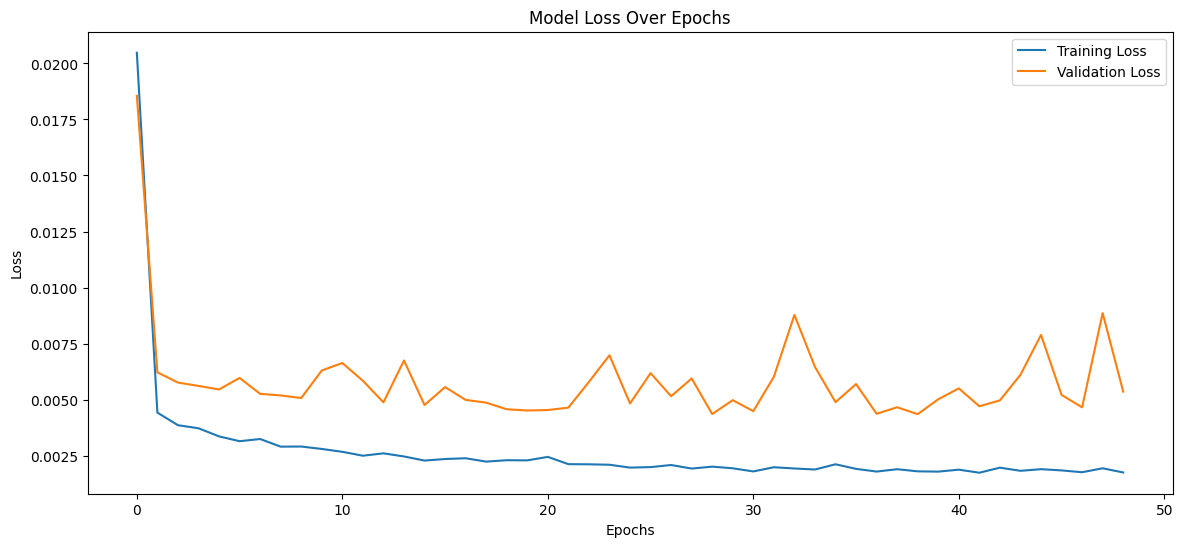

In [144]:
plt.figure(figsize=(14,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [145]:
predictions = model.predict(X_test)

# Reverse scaling for predictions and actuals
y_test_rescaled = scaler.inverse_transform(np.c_[y_test, np.zeros_like(y_test), np.zeros_like(y_test), np.zeros_like(y_test)])[:, 0]
predictions_rescaled = scaler.inverse_transform(np.c_[predictions, np.zeros_like(predictions), np.zeros_like(predictions), np.zeros_like(predictions)])[:, 0]


3/3 [==============================] - 0s 99ms/step


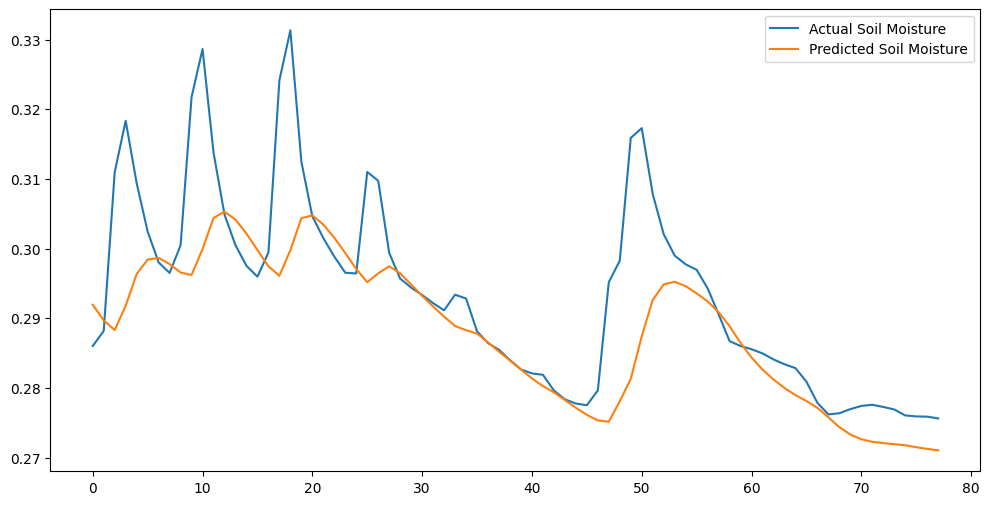

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Soil Moisture")
plt.plot(predictions_rescaled, label="Predicted Soil Moisture")
plt.legend()
plt.show()

In [148]:
# Get the last 195 days from the scaled data (adjusted for multi-feature input)
last_window = df_scaled[-window_size:]
last_window = last_window.reshape((1, window_size, len(features)))

# Predict the next day
next_day_pred_scaled = model.predict(last_window)

# Since the prediction is only for the soil moisture (first feature),
# create a template array to inverse transform
next_day_pred_template = np.zeros((1, len(features)))
next_day_pred_template[0, 0] = next_day_pred_scaled  # Only set the soil moisture

# Inverse transform the predicted value to get it back to the original scale
next_day_pred = scaler.inverse_transform(next_day_pred_template)

# Output the predicted soil moisture for the next day
print(f'Predicted Soil Moisture for the next day: {next_day_pred[0][0]}')


1/1 [==============================] - 0s 51ms/step
Predicted Soil Moisture for the next day: 0.27071700335458754


In [149]:
model.save_weights('Soil_m_weights_1.h5')
model.save('Soil_m_1.h5')